Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [187]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

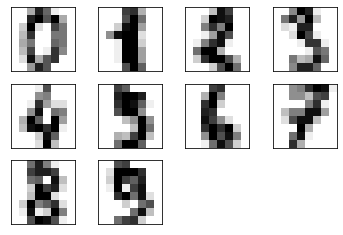

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn

for i in range(0, 10):
    ax = plt.subplot(3,4, i+1)
    im = ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [189]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=10).fit_predict(X)

In [190]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0, n_init=100)
kmeans.fit_predict(X)

array([8, 6, 6, ..., 6, 7, 7])

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

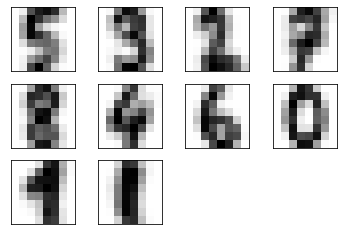

In [191]:
# AgglomerativeClustering

from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()
clf.fit(X, agglo)
centroids = clf.centroids_.reshape(10,8,8)

for i in range(0, 10):
    ax = plt.subplot(3,4, i+1)
    im = ax.imshow(centroids[i], cmap=plt.cm.binary, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

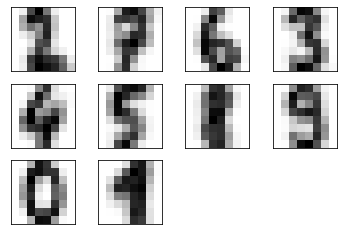

In [192]:
# K-Means Clustering

centers = kmeans.cluster_centers_.reshape(10, 8, 8)

for i in range(0, 10):
    ax = plt.subplot(3,4, i+1)
    im = ax.imshow(centers[i], cmap=plt.cm.binary, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

На мой взгляд оба алгоритма одинаково не очень справляются с чётким начертанием цифр, однако используя AgglomerativeClustering цифра 8 вычерчивается гораздо чётче, чем используя K-Means Clustering.

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [194]:
from sklearn.metrics import silhouette_score

agglo_silhouettes = []
agglo_n_iter = []

for i in range (2, 21):
    agglo = AgglomerativeClustering(n_clusters=i)
    agglo_clusters = agglo.fit_predict(X)
    silhouette_score_agglo = silhouette_score(X, agglo_clusters)
    
    agglo_silhouettes.append(silhouette_score_agglo)
    agglo_n_iter.append(i)
        
    #print("For n_clusters =", i, "The average silhouette_score is :", silhouette_score_agglo)
    
agglo_best_silhouette = max(agglo_silhouettes)
agglo_best_n_iter = agglo_silhouettes.index(max(agglo_silhouettes)) +2

In [195]:
km_silhouettes = []
km_n_iter = []

for i in range (2, 21):
     
    kmeans = KMeans(n_clusters=i, n_init=100, random_state=42)
    kmeans_clusters = kmeans.fit_predict(X)
    silhouette_score_kmeans = silhouette_score(X, kmeans_clusters)
    
    km_silhouettes.append(silhouette_score_kmeans)
    km_n_iter.append(i)
    
    #print("For n_clusters =", i, "The average silhouette_score is :", silhouette_score_kmeans)   
    
km_best_silhouette = max(km_silhouettes)
km_best_n_iter = km_silhouettes.index(max(km_silhouettes)) +2

Agglomerative Clustering max Silhouette Score : 0.18061975703867697, n_clusters: 9
K-Means Clustering max Silhouette Score : 0.1891928164889673, n_clusters: 9


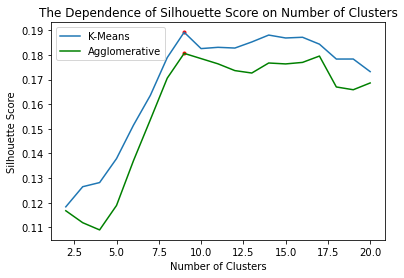

In [196]:
print (f'Agglomerative Clustering max Silhouette Score : {agglo_best_silhouette}, n_clusters: {agglo_best_n_iter}')

print (f'K-Means Clustering max Silhouette Score : {km_best_silhouette}, n_clusters: {km_best_n_iter}')

plt.plot(km_n_iter, km_silhouettes, label = 'K-Means')
plt.scatter(km_best_n_iter, km_best_silhouette, color='red', marker='.')
plt.plot(agglo_n_iter, agglo_silhouettes, label = 'Agglomerative', color = 'green')
plt.scatter(agglo_best_n_iter, agglo_best_silhouette, color='red', marker='.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title ('The Dependence of Silhouette Score on Number of Clusters')
plt.legend()

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [197]:
from sklearn.metrics import v_measure_score 

km_v_measure_score = []
km_n_iter = []

for i in range (2, 21):
     
    kmeans = KMeans(n_clusters=i, n_init=100, random_state=42)
    kmeans_clusters = kmeans.fit_predict(X)    
    km_v_measure_scores = v_measure_score(y, kmeans_clusters)
    
    km_v_measure_score.append(km_v_measure_scores)
    km_n_iter.append(i)
    
    #print("For n_clusters =", i, "The average v-measure is :", km_v_measure_scores)   
    
km_best_v_measure_score = max(km_v_measure_score)
km_best_n_iter = km_v_measure_score.index(max(km_v_measure_score)) +2

In [198]:
agglo_v_measure_score = []
agglo_n_iter = []

for i in range (2, 21):
     
    agglo = AgglomerativeClustering(n_clusters=i)
    agglo_clusters = agglo.fit_predict(X)    
    agglo_v_measure_scores = v_measure_score(y, agglo_clusters)
    
    agglo_v_measure_score.append(agglo_v_measure_scores)
    agglo_n_iter.append(i)
    
    #print("For n_clusters =", i, "The average v-measure is :", agglo_v_measure_scores)   
    
agglo_best_v_measure_score = max(agglo_v_measure_score)
agglo_best_n_iter = agglo_v_measure_score.index(max(agglo_v_measure_score)) +2

Agglomerative Clustering max V-measure Score : 0.86854875186737, n_clusters: 12
K-Means Clustering max V-measure Score : 0.7861749886360692, n_clusters: 18


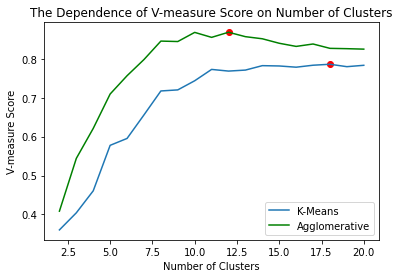

In [199]:
print (f'Agglomerative Clustering max V-measure Score : {agglo_best_v_measure_score}, n_clusters: {agglo_best_n_iter}')

print (f'K-Means Clustering max V-measure Score : {km_best_v_measure_score}, n_clusters: {km_best_n_iter}')


plt.plot(km_n_iter, km_v_measure_score, label = 'K-Means')
plt.scatter(km_best_n_iter, km_best_v_measure_score, color='red', marker='o')
plt.plot(agglo_n_iter, agglo_v_measure_score, label = 'Agglomerative', color = 'green')
plt.scatter(agglo_best_n_iter, agglo_best_v_measure_score, color='red', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('V-measure Score')
plt.title ('The Dependence of V-measure Score on Number of Clusters')
plt.legend()

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [200]:
from sklearn.decomposition import TruncatedSVD

In [201]:
n_components = [2, 5, 10, 20]

agglo_silhouette_svd = []
agglo_v_measure_svd = []

km_silhouette_svd = []
km_v_measure_svd = []


for n in n_components:
    svd = TruncatedSVD(n_components=n, n_iter=10, random_state=42)
    X_svd = svd.fit_transform(X)


    agglo = AgglomerativeClustering(n_clusters=10)

    agglo_clusters = agglo.fit_predict(X_svd)
    agglo_silhouette = silhouette_score(X_svd, agglo_clusters)
    agglo_v_measure_score = v_measure_score(y, agglo_clusters)
    
    agglo_silhouette_svd.append(agglo_silhouette)
    agglo_v_measure_svd.append(agglo_v_measure_score)


    kmeans = KMeans(n_clusters=10, random_state=0, n_init=100)

    km_clusters = kmeans.fit_predict(X_svd)
    km_silhouette =silhouette_score(X_svd, km_clusters)
    km_v_measure_score = v_measure_score(y, km_clusters)
    
    km_silhouette_svd.append(km_silhouette)
    km_v_measure_svd.append(km_v_measure_score)
    

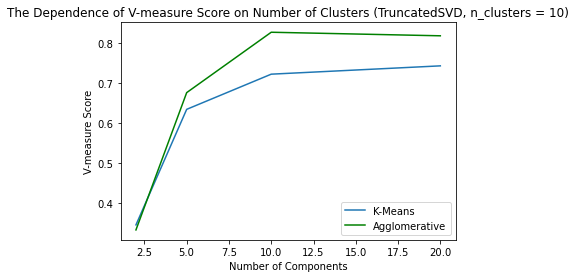

In [202]:
plt.plot(n_components, km_v_measure_svd, label = 'K-Means')
#plt.scatter(km_best_n_iter, km_best_v_measure_score, color='red', marker='o')
plt.plot(n_components, agglo_v_measure_svd, label = 'Agglomerative', color = 'green')
#plt.scatter(agglo_best_n_iter, agglo_best_v_measure_score, color='red', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('V-measure Score')
plt.title ('The Dependence of V-measure Score on Number of Clusters (TruncatedSVD, n_clusters = 10)')
plt.legend()

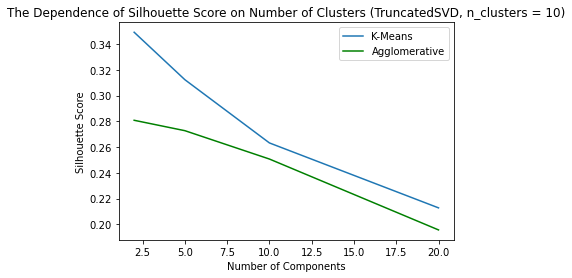

In [203]:
plt.plot(n_components, km_silhouette_svd, label = 'K-Means')
#plt.scatter(km_best_n_iter, km_best_v_measure_score, color='red', marker='o')
plt.plot(n_components, agglo_silhouette_svd, label = 'Agglomerative', color = 'green')
#plt.scatter(agglo_best_n_iter, agglo_best_v_measure_score, color='red', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title ('The Dependence of Silhouette Score on Number of Clusters (TruncatedSVD, n_clusters = 10)')
plt.legend()

In [204]:
best_agglo_silhouette_score = max(agglo_silhouette_svd)
best_km_silhouette_score = max(km_silhouette_svd)

best_agglo_v_measure_score = max(agglo_v_measure_svd)
best_km_v_measure_score = max(km_v_measure_svd)

print (f'Agglomerative clustering (TruncatedSVD): \nBest Silhouette Score: {best_agglo_silhouette_score}\nBest V-measure Score: {best_agglo_v_measure_score}')

print ('_____________________________________')

print (f'K-Means clustering (TruncatedSVD): \nBest Silhouette Score: {best_km_silhouette_score}\nBest V-measure Score: {best_km_v_measure_score}')

Agglomerative clustering (TruncatedSVD): 
Best Silhouette Score: 0.2808169849195823
Best V-measure Score: 0.8259753348813222
_____________________________________
K-Means clustering (TruncatedSVD): 
Best Silhouette Score: 0.34919269903814554
Best V-measure Score: 0.7422729794392336


После уменьшения размерности с помощью алгоритма TruncatedSVD получилось улучшение показателей силуэта как для иерархической кластеризации, так и для кластеризации K-Means. При этом, значения V-меры немного ухудшились.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [205]:
from sklearn.manifold import TSNE

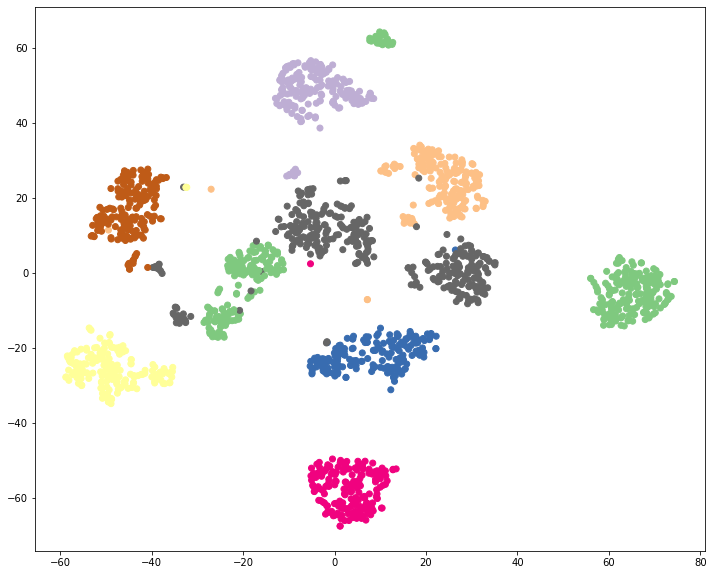

In [206]:
X_tsne = TSNE(random_state=42).fit_transform(X)
plt.figure(figsize=(12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.get_cmap('Accent', 10));

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [207]:
agglo = AgglomerativeClustering(n_clusters=10)

agglo_clusters = agglo.fit_predict(X_tsne)
agglo_silhouette = silhouette_score(X_tsne, agglo_clusters)
agglo_v_measure_score = v_measure_score(y, agglo_clusters)


kmeans = KMeans(n_clusters=10, random_state=0, n_init=100)

km_clusters = kmeans.fit_predict(X_tsne)
km_silhouette =silhouette_score(X_tsne, km_clusters)
km_v_measure_score = v_measure_score(y, km_clusters)

In [208]:

print (f'Agglomerative clustering (tSNE): \nSilhouette Score: {agglo_silhouette}\nV-measure Score: {agglo_v_measure_score}')

print ('_____________________________________')

print (f'K-Means clustering (tSNE): \nSilhouette Score: {km_silhouette}\nV-measure Score: {km_v_measure_score}')

Agglomerative clustering (tSNE): 
Silhouette Score: 0.6421834230422974
V-measure Score: 0.9111471953871231
_____________________________________
K-Means clustering (tSNE): 
Silhouette Score: 0.6432376503944397
V-measure Score: 0.9137798316714036


Мы наблюдаем просто космический прирост для значения силуэта и V-меры вне зависимости от алгоритма кластеризации.

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

Самое лучшее разбиение получилось при K-Means кластеризации при числе кластеров 10  с использованием алгоритма tSNE. В данном случае получилось максимальное значение силуэта среди всех "экспериментов".

In [209]:
# K-Means

kmeans = KMeans(n_clusters=10, random_state=0, n_init=100).fit(X_tsne)

km_clusters = kmeans.fit_predict(X)

km_silhouette =silhouette_score(X_tsne, km_clusters)
km_v_measure_score = v_measure_score(y, km_clusters)


centers = kmeans.cluster_centers_.reshape(10,8,8)

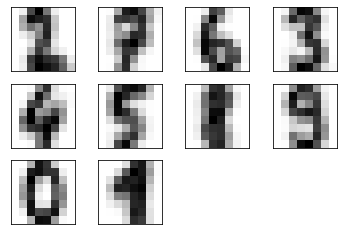

In [210]:
for i in range(0, 10):
    ax = plt.subplot(3,4, i+1)
    im = ax.imshow(centers[i], cmap=plt.cm.binary, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

Кажется, очертания цифр стали несколько чётче, но всё же размыто и не совсем понятно. Некоторые цифры можно однозначно определить, но по-прежнему есть проблемы с начертанием цифры 8.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

На мой взгляд оба алгоритма справляются в равной степени, однако при использовании K-Means и уменьшении размерности были получены лучшие показатели силуэта и V-меры. 
Если говорить о сырых данных, то лучшее значение силуэта получается при алгоритме K-Means, но лучшие показатели V-меры при иерархической калстеризации.

При снижении размерности признакового пространства значительно улучшаются показатели силуэта и V-меры, видно лёгкое улучшение в начертании цифр.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [172]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [173]:
X_tsne = TSNE(random_state=42, n_jobs=-1).fit_transform(X)
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42).fit_predict(X_tsne)
print(f'Silhouette score: {silhouette_score(X_tsne, kmeans)}')
print(f'V-measure score: {v_measure_score(y, kmeans)}')

Silhouette score: 0.385738343000412
V-measure score: 0.7492057867924364


In [175]:
from umap import UMAP
X_umap = UMAP(random_state=42, n_jobs=-1).fit_transform(X)
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42).fit_predict(X_umap)
print(f'Silhouette score: {silhouette_score(X_umap, kmeans)}')
print(f'V-measure score: {v_measure_score(y, kmeans)}')

Silhouette score: 0.5950158834457397
V-measure score: 0.8376595020998507


In [184]:
param_list = {
    'reduction__min_dist': [0.05, 0.1, 0.15, 0.2],
    'reduction__n_neighbors': list(range(10, 16)),
    'reduction__n_components': list(range(10, 16)),
}
model = Pipeline([('reduction', UMAP(n_jobs=-1)),
                 ('clustering', KMeans(n_clusters=10, n_init=10, random_state=42))])
result = RandomizedSearchCV(model, param_list, scoring='v_measure_score', n_iter=10, cv=5, random_state=42, n_jobs=-1).fit(X, y)
print(f'Best V-measure score: {result.best_score_}')
print(f'Best parameters: {result.best_params_}')

Best V-measure score: 0.663587912999531
Best parameters: {'reduction__n_neighbors': 10, 'reduction__n_components': 13, 'reduction__min_dist': 0.05}


In [185]:
X_umap = UMAP(n_neighbors=10, n_components=13, min_dist=0.05, random_state=42, n_jobs=-1).fit_transform(X)
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42).fit_predict(X_umap)
print(f'Silhouette score: {silhouette_score(X_umap, kmeans)}')
print(f'V-measure score: {v_measure_score(y, kmeans)}')

Silhouette score: 0.674439549446106
V-measure score: 0.8618134810310071


**Обоснование выбора**

На опыте предыдущих экспериментов самые лучшие значения силуэта и V-меры получились при уменьшении размерности алгоритмом TruncatedSVD. Сначала пробую использовать его, значение V-меры приличное, но всё же оставляет желать лучшего. В лекции был упомянут UMAP, применяя его с дефолтными настройками получилось добиться гораздо более высоких значений силуэта и V-меры. Если немножко "потюнить" параметры, то можно добиться показателей получше, но это стоит примерно час времени :)